<a href="https://colab.research.google.com/github/faisalahm3d/Brain-Tumor-Classification-Using-Transfer-Learning/blob/main/DeepPhoPred_Curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,recall_score, matthews_corrcoef, precision_score, roc_auc_score, f1_score
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, auc
import numpy as np
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, roc_curve
from matplotlib import pyplot 

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

In [ ]:
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, MaxPooling1D, Flatten,concatenate,GlobalMaxPool1D
from keras import Model
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras import regularizers
from keras.regularizers import (l1, l2, l1_l2)
from keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,GlobalAveragePooling1D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate, Multiply)

In [ ]:
def performance_result(y_test,y_test_predict,y_test_prob):
  precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
  res = "              Experimental result with combined features\n"
  res += "-----------------------------------------------------------------\n"
  res += "             independent test\n"
  res += "-----------------------------------------------------------------\n"
  res += "Accuracy:    {0:0.1f}\n".format(accuracy_score(y_test, y_test_predict)*100)
  res += "MCC:         {0:0.2f}\n".format(matthews_corrcoef(y_test, y_test_predict))
  res += "Precision:   {0:0.2f}\n".format(precision_score(y_test, y_test_predict))
  res += "Roc AUC :    {0:0.2f}\n".format(roc_auc_score(y_test, y_test_predict))
  res += "F1 score:    {0:0.2f}\n".format(f1_score(y_test, y_test_predict))
  res += "Sensitivity: {0:0.1f}\n".format(recall_score(y_test, y_test_predict)*100)
  res += "Specificity: {0:0.1f}\n".format(specificity_score(y_test, y_test_predict)*100)
  res += "PR AUC: {0:0.2f}\n".format(auc(recall, precision))

  # draw_roc_curve(y_test,y_test_predict_prob)
  print(res)
  tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
  print("Tn: {} Fp : {} Fn : {} Tp : {}\n\n".format(tn, fp, fn , tp))

In [ ]:
def generate_new_test_undersample(x_val,y_val,x_test,y_test):
  # prepare independent test data for downsampling
  new_test_x = []
  new_test_y = []
  pos_count = 340
  neg_count = 4206
  ratio = int(neg_count/pos_count)
  new_val_x = np.array(x_val.tolist() * ratio)
  new_val_y = np.array(y_val.tolist() * ratio)
  count = 0
  for i in range(len(new_val_y)):
    if new_val_y[i] == 1:
      new_test_x.append(new_val_x[i])
      new_test_y.append(1)
      count += 1
      if count == pos_count - 120:
        break
  count = 0
  for i in range(len(new_val_y)):
    if new_val_y[i] == 0:
      new_test_x.append(new_val_x[i])
      new_test_y.append(0)
      count += 1
      if count == neg_count - 150:
        print('available validation data')
        break

  count = 0
  for i in range(len(y_test)):
    if y_test[i] == 1:
      new_test_x.append(x_test[i])
      new_test_y.append(1)
      count += 1
      if count == 120:
        break
  count = 0
  for i in range(len(y_test)):
    if y_test[i] == 0:
      new_test_x.append(x_test[i])
      new_test_y.append(0)
      count += 1
      if count == 150:
        print('available test data')
        break
  new_test_x = np.stack(new_test_x)
  new_test_y = np.stack(new_test_y)
  return new_test_x, new_test_y

In [ ]:
def generate_new_test_oversampling(x_val, y_val,x_test, ytest):
  # for oversampling
  new_test_x = []
  new_test_y = []
  pos_count = 284
  neg_count = 1635
  count = 0
  for i in range(len(y_val)):
    if y_val[i] == 1:
      new_test_x.append(x_val[i])
      new_test_y.append(1)
      count += 1
      if count == pos_count - 100:
        break
  count = 0
  for i in range(len(y_val)):
    if y_val[i] == 0:
      new_test_x.append(x_val[i])
      new_test_y.append(0)
      count += 1
      if count == neg_count - 1000:
        print('Enough Validation Data')
        break

  count = 0
  for i in range(len(y_test)):
    if y_test[i] == 1:
      new_test_x.append(x_test[i])
      new_test_y.append(1)
      count += 1
      if count == 100:
        break
  count = 0
  for i in range(len(y_test)):
    if y_test[i] == 0:
      new_test_x.append(x_test[i])
      new_test_y.append(0)
      count += 1
      if count == 1000:
        print('Enough test Data')
        break
  new_test_x = np.stack(new_test_x)
  new_test_y = np.stack(new_test_y)
  return new_test_x, new_test_y

In [ ]:
def get_pssm_spd(data):
  row, col = data.shape
  print (row)
  pssm= data[:, :620]
  spd = data[:, 620:]
  return np.array([pssm[r,:].reshape(31,20) for r in range(row)]), np.array([spd[r, :].reshape(31,8) for r in range(row)])

In [ ]:
def plot_roc_curves(fpr, tpr, roc_auc, label,protein_site,colors):
    plt.figure()
    lw = 1.0
    #colors = ['green', 'darkorange', 'red']
    for i in range(len(label)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw, label='p{0} {1} (AUC = {2:0.2f})'.format(protein_site,label[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)

    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.figure(figsize=(30,10))
    plt.savefig('roc_curve_final'+protein_site+'.png', dpi=500)
    plt.show()

In [ ]:
def plot_pr_curves(fpr, tpr, pr_auc, label, protein_site, colors):
    plt.figure()
    lw = 1.0
    #colors = ['green', 'darkorange', 'red']
    for i in range(len(label)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=lw, label='p{0} {1} (AUC = {2:0.2f})'.format(protein_site,label[i], pr_auc[i]))

    #plt.plot([0, 1], [1, 0], 'k--', lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower left")
    # plt.figure(figsize=(30,10))
    plt.savefig('pr_curve_p'+protein_site+'.png', dpi=500)
    plt.show()

In [ ]:
npzfile = np.load('/content/drive/MyDrive/Dataset/independent_test_set_T.npz', allow_pickle=True)
new_test_x = npzfile['arr_0']
new_test_y = npzfile['arr_1']

In [ ]:
import numpy as np
#npzfile = np.load('/content/drive/MyDrive/Dataset/train_smote_balanced_15_Y.npz', allow_pickle=True)
npzfile = np.load('/content/drive/MyDrive/Dataset/smote_trained_balanced_bigram_Y.npz', allow_pickle=True)
x_train= npzfile['arr_0']
y_train= npzfile['arr_1']
x_test = npzfile['arr_2']
y_test = npzfile['arr_3']
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=10)

In [ ]:
row_test_x, row_test_y = generate_new_test_oversampling(x_val,y_val,x_test,y_test)

NameError: ignored

In [ ]:
import numpy as np
#npzfile = np.load('/content/drive/MyDrive/Dataset/train_smote_balanced_15_Y.npz', allow_pickle=True)
npzfile = np.load('/content/drive/MyDrive/Dataset/nearmiss_bigram_trained_balanced_S.npz', allow_pickle=True)
x_train= npzfile['arr_0']
y_train= npzfile['arr_1']
x_test = npzfile['arr_2']
y_test = npzfile['arr_3']
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=10)

In [ ]:
nearmiss_test_x, nearmiss_test_y = generate_new_test_undersample(x_val,y_val,x_test,y_test)

available validation data
available test data


In [ ]:
len(nearmiss_test_x[0])

488

In [ ]:
np.savez('/content/drive/MyDrive/Dataset/independent_test_set_S_smote_row.npz', row_test_x, row_test_y)

In [ ]:
pos = 0
neg = 0
for i in range(len(row_test_y)):
  if row_test_y[i]== 1:
    pos +=1
  elif row_test_y[i]==0:
    neg +=1
print(pos)
print(neg)

284
1635


In [ ]:
pos = 0
neg = 0
for i in range(len(nearmiss_test_y)):
  if nearmiss_test_y[i]== 1:
    pos +=1
  elif nearmiss_test_y[i]==0:
    neg +=1
print(pos)
print(neg)

340
4206


In [ ]:
testX1, testX2 = get_pssm_spd(new_test_x)
#nearmissX1, nearmissX2 = get_pssm_spd(nearmiss_test_x)

2832


In [ ]:
from tensorflow.keras.models import load_model
#model_spd = load_model('/content/drive/MyDrive/Dataset/best_model_spd-Y.h5')
#model_pssm = load_model('/content/drive/MyDrive/Dataset/best_model_combined_nearmiss_S.h5')
model_combined = load_model('/content/drive/MyDrive/Dataset/best_model_combined_T_ind.h5')

#probabilities_pssm = model_pssm.predict([nearmissX1,nearmissX2])
#predicted_classes_pssm = probabilities_pssm >= 0.5
#predicted_classes_pssm = predicted_classes_pssm.astype(int)

#probabilities_spd = model_spd.predict([testX2])
#predicted_classes_spd = probabilities_spd >= 0.5
#predicted_classes_spd = predicted_classes_spd.astype(int)

probabilities_combined = model_combined.predict([testX1,testX2])
predicted_classes_combined = probabilities_combined >= 0.5
predicted_classes_combined = predicted_classes_combined.astype(int)

In [ ]:
!pip install rotation-forest
import pickle
from rotation_forest import RotationForestClassifier
protein_site = 'T'
label =['cnn','rf','gb','rof','adaboost','svm',]
label_manipulated =['cnn','rof','rf','svm','gb','adaboost']

fpr = dict()
tpr = dict()
roc_auc = dict()
pr = dict()
re = dict()
threshold = dict()
pr_auc = dict()
for i in range(1, len(label)):
  modelfile = open('/content/drive/MyDrive/Dataset/ml-models-bigram-features/p{}smote-final-{}.pkl'.format(protein_site,label[i]), 'rb')
  #modelfile = open('/content/drive/MyDrive/Dataset/ml-models/p{}nearmiss-final-{}.pkl'.format(protein_site,label[i]), 'rb')
  ml_model = pickle.load(modelfile)
  y_pred= ml_model.predict(row_test_x)
  y_pred_prob = ml_model.predict_proba(row_test_x)
  probabilities = []
  for j in range(len(y_pred_prob)):
    prob = y_pred_prob[j][1]
    probabilities.append(prob)
  y_proba = np.array(probabilities)
  performance_result(row_test_y,y_pred,y_proba)
  fpr[i], tpr[i], _ = roc_curve(row_test_y, y_proba)
  #roc_auc[2] = metrics.auc(fpr[2], tpr[2])
  roc_auc[i] = roc_auc_score(row_test_y, y_pred)
  pr[i], re[i], _ = precision_recall_curve(row_test_y, y_proba)
  #ind = np.argsort(pr[2])
  #pr[2] = pr[2][ind]
  #re[2] = re[2][ind]
  #pr_auc[2] = metrics.auc(pr[2], re[2])
  pr_auc[i] = auc(re[i],pr[i])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


              Experimental result with combined features
-----------------------------------------------------------------
             independent test
-----------------------------------------------------------------
Accuracy:    95.4
MCC:         0.68
Precision:   0.89
Roc AUC :    0.78
F1 score:    0.69
Sensitivity: 56.1
Specificity: 99.3
PR AUC: 0.68

Tn: 2561 Fp : 18 Fn : 111 Tp : 142


              Experimental result with combined features
-----------------------------------------------------------------
             independent test
-----------------------------------------------------------------
Accuracy:    84.6
MCC:         0.38
Precision:   0.32
Roc AUC :    0.76
F1 score:    0.43
Sensitivity: 65.2
Specificity: 86.5
PR AUC: 0.54

Tn: 2232 Fp : 347 Fn : 88 Tp : 165




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.6s finished


              Experimental result with combined features
-----------------------------------------------------------------
             independent test
-----------------------------------------------------------------
Accuracy:    81.9
MCC:         0.31
Precision:   0.27
Roc AUC :    0.72
F1 score:    0.37
Sensitivity: 59.3
Specificity: 84.1
PR AUC: 0.45

Tn: 2170 Fp : 409 Fn : 103 Tp : 150


              Experimental result with combined features
-----------------------------------------------------------------
             independent test
-----------------------------------------------------------------
Accuracy:    80.2
MCC:         0.29
Precision:   0.25
Roc AUC :    0.71
F1 score:    0.35
Sensitivity: 59.7
Specificity: 82.2
PR AUC: 0.44

Tn: 2121 Fp : 458 Fn : 102 Tp : 151


              Experimental result with combined features
-----------------------------------------------------------------
             independent test
-----------------------------------------------------

In [ ]:
!pip install rotation-forest
import pickle
from rotation_forest import RotationForestClassifier
protein_site = 'S'
label =['','-pssm','-spd']
algo = ['svm','rf']
label_manipulated =['Combined','Evolutionary','Structural']
inp ={0:nearmiss_test_x,
      1:nearmiss_test_x[:,:400],
      2:nearmiss_test_x[:,400:]
      }
outp = {
    0:nearmiss_test_y,
    1:nearmiss_test_y,
    2:nearmiss_test_y

}

fpr = dict()
tpr = dict()
roc_auc = dict()
pr = dict()
re = dict()
threshold = dict()
pr_auc = dict()

for i in range(len(label)):
  modelfile = open('/content/drive/MyDrive/Dataset/ml-models-bigram-features/p{}nearmiss-final-svm{}.pkl'.format(protein_site,label[i]), 'rb')
  #modelfile = open('/content/drive/MyDrive/Dataset/ml-models/p{}nearmiss-final-{}.pkl'.format(protein_site,label[i]), 'rb')
  ml_model = pickle.load(modelfile)
  y_pred= ml_model.predict(inp[i])
  y_pred_prob = ml_model.predict_proba(inp[i])
  probabilities = []
  for j in range(len(y_pred_prob)):
    prob = y_pred_prob[j][1]
    probabilities.append(prob)
  y_proba = np.array(probabilities)
  performance_result(outp[i],y_pred,y_proba)
  fpr[i], tpr[i], _ = roc_curve(outp[i], y_proba)
  #roc_auc[2] = metrics.auc(fpr[2], tpr[2])
  roc_auc[i] = roc_auc_score(outp[i], y_pred)
  pr[i], re[i], _ = precision_recall_curve(outp[i], y_proba)
  #ind = np.argsort(pr[2])
  #pr[2] = pr[2][ind]
  #re[2] = re[2][ind]
  #pr_auc[2] = metrics.auc(pr[2], re[2])
  pr_auc[i] = auc(re[i],pr[i])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
              Experimental result with combined features
-----------------------------------------------------------------
             independent test
-----------------------------------------------------------------
Accuracy:    95.4
MCC:         0.72
Precision:   0.65
Roc AUC :    0.90
F1 score:    0.73
Sensitivity: 84.1
Specificity: 96.3
PR AUC: 0.68

Tn: 4052 Fp : 154 Fn : 54 Tp : 286


              Experimental result with combined features
-----------------------------------------------------------------
             independent test
-----------------------------------------------------------------
Accuracy:    93.9
MCC:         0.53
Precision:   0.60
Roc AUC :    0.75
F1 score:    0.56
Sensitivity: 51.8
Specificity: 97.3
PR AUC: 0.54

Tn: 4091 Fp : 115 Fn : 164 Tp : 176


              Experimental result with combined features
---------------------------------------------------

In [ ]:
len(inp[0][0])

648

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#label = ('Structural', 'Evolutionary', 'combined')
#label = ('NearMiss', 'SMOTE')

#fpr[0], tpr[0], _ = metrics.roc_curve(new_test_y, probabilities_spd)
#roc_auc[0] = metrics.auc(fpr[0], tpr[0])
#roc_auc[0] = roc_auc_score(new_test_y, predicted_classes_spd)

#fpr[0], tpr[0], _ = metrics.roc_curve(nearmiss_test_y, probabilities_pssm)
#roc_auc[1] = metrics.auc(fpr[1], tpr[1])
#roc_auc[0] = roc_auc_score(nearmiss_test_y, predicted_classes_pssm)

fpr[0], tpr[0], _ = metrics.roc_curve(new_test_y, probabilities_combined)
#roc_auc[2] = metrics.auc(fpr[2], tpr[2])
roc_auc[0] = roc_auc_score(new_test_y, predicted_classes_combined)


In [ ]:
for i in range(1,len(label)):
  fpr[i], tpr[i], _ = metrics.roc_curve(row_test_y, proba_ind)
  #roc_auc[2] = metrics.auc(fpr[2], tpr[2])
  roc_auc[i] = roc_auc_score(row_test_y, y_pred)

In [ ]:
roc_auc

{0: 0.6845960149397613,
 1: 0.6845960149397613,
 2: 0.6845960149397613,
 3: 0.6845960149397613,
 4: 0.6845960149397613,
 5: 0.6845960149397613}

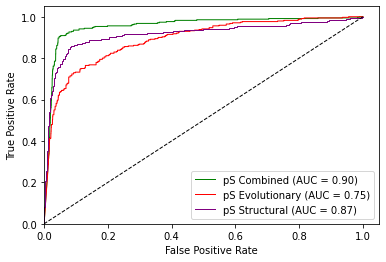

In [ ]:
protein_site = 'S'
import matplotlib.pyplot as plt
#colors = ['green', 'red','purple','darkorange', 'pink','cyan']
colors = ['green', 'red','purple']
plot_roc_curves(fpr, tpr, roc_auc,label_manipulated,protein_site, colors)

In [ ]:
#pr = dict()
#re = dict()
#threshold = dict()
#pr_auc = dict()
#label = ('Structural', 'Evolutionary', 'combined')

#pr[0], re[0], threshold[0] = precision_recall_curve(new_test_y, probabilities_spd)
#ind = np.argsort(pr[0])
#pr[0] = pr[0][ind]
#re[0] = re[0][ind]
#pr_auc[0] = metrics.auc(pr[0], re[0])
#pr_auc[0] = metrics.auc(re[0],pr[0])
#roc_auc[0] = roc_auc_score(new_test_y, predicted_classes_spd)

#pr[0], re[0], threshold[0] = precision_recall_curve(new_test_y, probabilities_combined)
#ind = np.argsort(pr[1])
#pr[1] = pr[1][ind]
#re[1] = re[1][ind]
#pr_auc[1] = metrics.auc(pr[1], re[1])
#pr_auc[0] = metrics.auc(re[0],pr[0])


pr[0], re[0], _ = precision_recall_curve(new_test_y, probabilities_combined)
#ind = np.argsort(pr[2])
#pr[2] = pr[2][ind]
#re[2] = re[2][ind]
#pr_auc[2] = metrics.auc(pr[2], re[2])
pr_auc[0] = metrics.auc(re[0],pr[0])

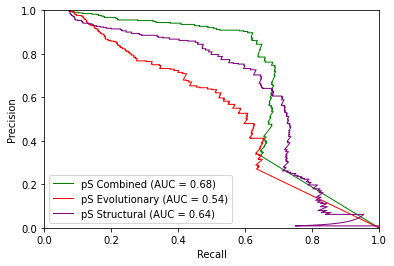

In [ ]:
plot_pr_curves(pr, re, pr_auc,label_manipulated,protein_site, colors)